# Titanic - Machine Learning from Disaster

### The Challenge  

The sinking of the Titanic is one of the most infamous shipwrecks in history.  
  
On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.  
  
While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.  
  
In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).  

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn import preprocessing
from sklearn import model_selection

In [152]:
train = pd.read_csv('data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Пропуски

In [53]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [54]:
# смотрим количество пропусков
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [128]:
# у признака Cabin слишком мног пропусков, удалим его
train.drop(['Cabin'], axis=1, inplace=True)
# 
train = train.fillna({'Age':train['Age'].median()})
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [129]:
# проверим дубликаты
train.duplicated().sum()

0

### Выбросы

In [130]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [131]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


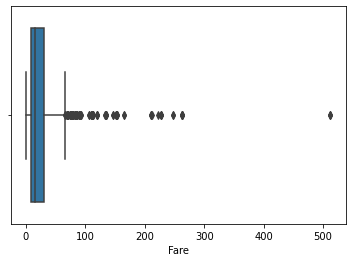

In [132]:
# рассмотрим тариф, выглядит, что есть выбросы
sns.boxplot(
    data=train,
    x = 'Fare'
);

In [68]:
# видим, что это не выбросы, а действительно более дорогие билеты (погуглила, что люди из самых дорогих кают действительно там и были). 
# Логично, что более бюджетных билетов значительно больше
mask = train['Fare']> 100
train[mask]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,C
195,196,1,1,"Lurette, Miss. Elise",female,58.00,0,0,PC 17569,146.5208,C
215,216,1,1,"Newell, Miss. Madeleine",female,31.00,1,0,35273,113.2750,C
258,259,1,1,"Ward, Miss. Anna",female,35.00,0,0,PC 17755,512.3292,C
268,269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.00,0,1,PC 17582,153.4625,S
269,270,1,1,"Bissette, Miss. Amelia",female,35.00,0,0,PC 17760,135.6333,S
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,S
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,C


### Преобразование признаков

In [133]:
# удалим столбец с id пассажиров
train.drop(['PassengerId'], axis=1,inplace=True)

In [134]:
# удалим столбец с именами
train.drop(['Name'], axis=1,inplace=True)

In [135]:
train.drop(['Ticket'], axis=1,inplace=True)

In [136]:
train_clean = pd.get_dummies(train, columns=['Pclass', 'Sex', 'SibSp', 'Parch','Embarked'])
train_clean

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,0,0,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,38.0,71.2833,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,1,26.0,7.9250,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,35.0,53.1000,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,35.0,8.0500,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,13.0000,0,1,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
887,1,19.0,30.0000,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
888,0,28.0,23.4500,0,0,1,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
889,1,26.0,30.0000,1,0,0,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0


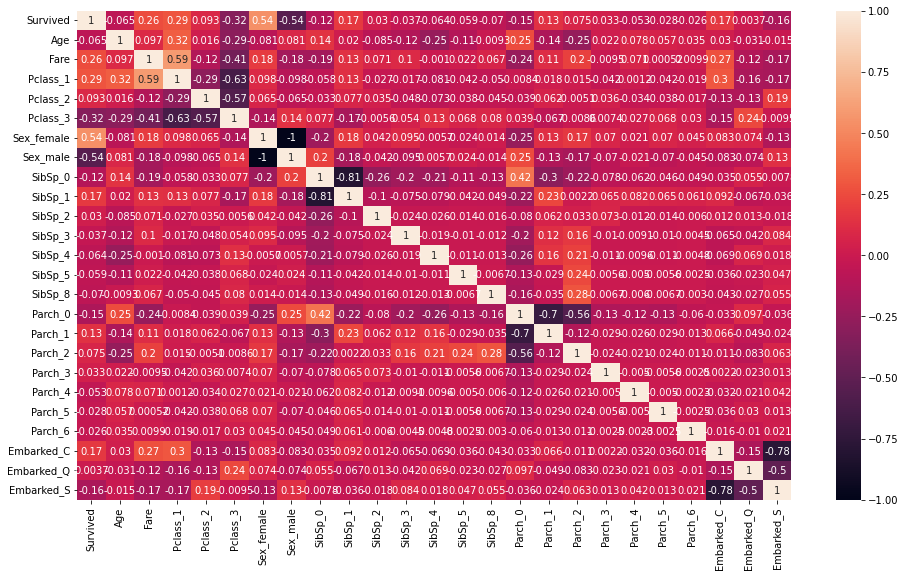

In [137]:
fig = plt.figure(figsize=(16,9))
sns.heatmap(
    train_clean.corr(),
    annot=True);

In [138]:
train_clean.drop(['Sex_female','SibSp_0', 'Embarked_S'], axis=1,inplace=True)

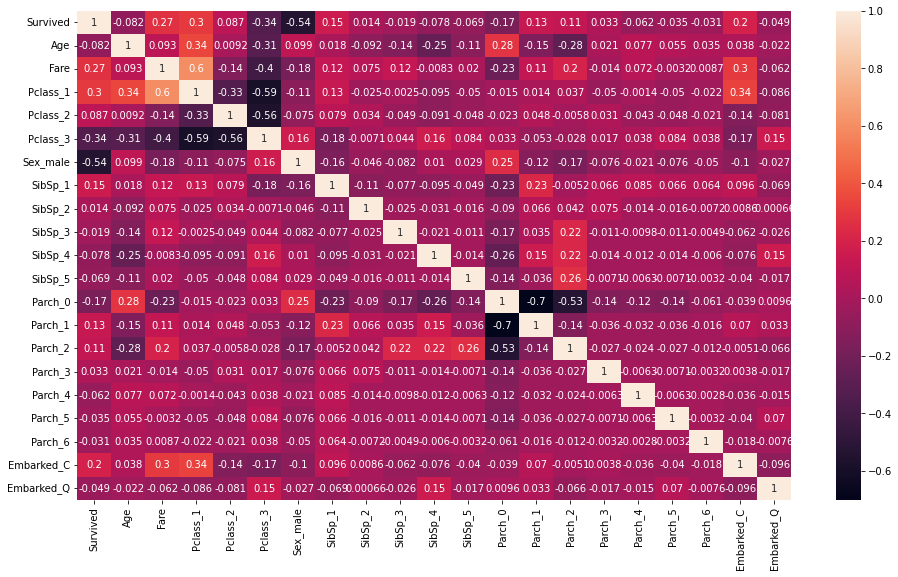

In [88]:
fig = plt.figure(figsize=(16,9))
sns.heatmap(
    train_clean.corr(),
    annot=True);

In [228]:
# обернем все изменения в одну функцию, чтобы потом прогнать через неё тестовые данные
def changes(X):
    X = X.drop(['Cabin', 'Name', 'Ticket','PassengerId'], axis=1)
    X = X.fillna({'Age':X['Age'].median()})
    X = pd.get_dummies(X, columns=['Sex','Embarked'])
    # X = pd.get_dummies(X, columns=['Pclass', 'Sex', 'SibSp', 'Parch','Embarked'])
    # X = X.drop(['Sex_female','SibSp_0', 'Embarked_S'], axis=1)
    return X

In [229]:
train = pd.read_csv('data/train.csv')
train_clean = changes(train)

### Моделирование

In [230]:
X = train_clean.drop(['Survived'], axis=1)
y = train_clean['Survived']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=0.33,random_state = 42)

In [212]:
X_train_norm = X_train
X_test_norm = X_test

In [231]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

### ЛОГИСТИЧЕСКАЯ

In [232]:
# начнем с логистической регресии
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 42)
lr.fit(X_train_norm, y_train)
y_pred_lr = lr.predict(X_test_norm)
lr.score(X_test_norm, y_test)

0.8169491525423729

### ДЕРЕВО

In [233]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth = 10,
    min_samples_leaf=3,
    random_state = 42)
dt.fit(X_train_norm, y_train)
y_pred_dt = dt.predict(X_test_norm)
dt.score(X_test_norm, y_test)

0.7762711864406779

In [234]:
# подберем параметры для дерева
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(3, 20) ,# глубина дерева
              'min_samples_leaf': range(2,6)
              }

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(
        random_state=42, #генератор случайных чисел
    ), 
    param_grid=param_grid,
    n_jobs = -1
)  
grid_search.fit(X_train_norm, y_train) 
grid_search.score(X_test_norm, y_test)

0.8101694915254237

### Случайный лес

In [237]:
from sklearn import ensemble
param_grid = {
    'max_depth': range(3, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

grid_search = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(
        random_state=42, #генератор случайных чисел
    ), 
    param_grid=param_grid,
    cv= 5,
    n_jobs = -1,
    scoring='accuracy'
)  
grid_search.fit(X_train_norm, y_train) 
grid_search.score(X_test_norm, y_test)

0.823728813559322

### Градиентный бустинг

In [236]:
param_grid = {
    'max_depth': range(3, 16),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

grid_search = model_selection.GridSearchCV(
    estimator=ensemble.GradientBoostingClassifier(
        random_state=42, #генератор случайных чисел
    ), 
    param_grid=param_grid,
    cv= 5,
    n_jobs = -1,
    scoring='accuracy'
)  
grid_search.fit(X_train_norm, y_train) 
grid_search.score(X_test_norm, y_test)

0.8169491525423729

## Делаем предсказание

In [238]:
# подгатавливаем тестовые данные по сценарию тренировочных
test = pd.read_csv('data/test.csv')
test = changes(test)
#test = test.drop('Parch_9', axis=1)
test

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0,1,0,1,0
1,3,47.0,1,0,7.0000,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,1,0,0,1
4,3,22.0,1,1,12.2875,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
413,3,27.0,0,0,8.0500,0,1,0,0,1
414,1,39.0,0,0,108.9000,1,0,1,0,0
415,3,38.5,0,0,7.2500,0,1,0,0,1
416,3,27.0,0,0,8.0500,0,1,0,0,1


In [186]:
# проверяем пропуски
test.isnull().sum()

Age           0
Fare          1
Pclass_1      0
Pclass_2      0
Pclass_3      0
Sex_male      0
SibSp_1       0
SibSp_2       0
SibSp_3       0
SibSp_4       0
SibSp_5       0
SibSp_8       0
Parch_0       0
Parch_1       0
Parch_2       0
Parch_3       0
Parch_4       0
Parch_5       0
Parch_6       0
Embarked_C    0
Embarked_Q    0
dtype: int64

In [239]:
# заменим проппуск медианой
test = test.fillna({'Fare':test['Fare'].median()})
test

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0,1,0,1,0
1,3,47.0,1,0,7.0000,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,1,0,0,1
4,3,22.0,1,1,12.2875,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
413,3,27.0,0,0,8.0500,0,1,0,0,1
414,1,39.0,0,0,108.9000,1,0,1,0,0
415,3,38.5,0,0,7.2500,0,1,0,0,1
416,3,27.0,0,0,8.0500,0,1,0,0,1


In [240]:
# стандартизируем (как и тренировочные данные)
test_norm = scaler.transform(test)

In [241]:
y_pred = grid_search.predict(test_norm)
# подготовливаем таблицу для kaggle
submission = pd.DataFrame({'PassengerId': range(892,1310), 'Survived':y_pred})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [242]:
# submission.to_csv('data/submission_1_grid_tree.csv', index=False)
# submission.to_csv('data/submission_2_grid_forest.csv', index=False)
submission.to_csv('data/submission_3_grid_forest_without_kod.csv', index=False)